In [1]:
import openpyxl
import numpy as np
from sklearn import preprocessing

## Abrir Excel con Datos
file_train = 'CREDITRISK_RAW.xlsx'
wb = openpyxl.load_workbook(file_train)
sheet = wb.get_sheet_by_name('Sheet1')
sheet = wb.active

# Forma matriz para contener datos
columns = 20
rows = 2294
data_matrix = np.zeros(shape=(rows, columns))

# Columnas con datos no numericos, se deben pasar a labels numericos usando un LabelEncoder
non_numerical_columns = [1, 4, 5, 8, 18, 19]  ##
non_numerical_info = []
clases = []
clases_num_encode = []
features_names = []
empty_cell = sheet.cell(row=85, column=8).value  ## Ejemplo de celda vacia

for i in range(columns):
    j = 0
    column_i = []
    
    flag_non_numeric = False
    flag_append = True
    
    # Verificar si la columna es de datos no numericos
    if i in non_numerical_columns:
        flag_non_numeric = True
            
    for cellObj in sheet.columns[i]:
        if j > 0:
            if (cellObj.value == empty_cell) and (not flag_non_numeric):
            #if (cellObj.value == empty_cell):
                #flag_append = False
                column_i.append(0)
            else:
                column_i.append(cellObj.value)
        
        else:
            name = cellObj.value
            if i>0:
                features_names.append(name)
            print name
            
            
        j += 1
    
    
    if flag_non_numeric:
        le = preprocessing.LabelEncoder()
        le.fit(column_i)
        clases.append(list(le.classes_))  
        non_numerical_info.append(sheet.cell(row=1, column=i+1).value)
        
        # Encode de datos
        column_i = le.transform(column_i)
      
    if flag_append:
        data_matrix[:,i] = column_i
    else:
        print name + " no added"

   

ID
GENERO
RENTA
EDAD
NIV_EDUC
E_CIVIL
COD_OFI
COD_COM
CIUDAD
Crédito_1
Crédito_2
Crédito_3
Crédito_4
Monto solicitado
Días de Mora
Monto Deuda Promedio
Número de meses inactivo
numero de cuotas
Aval
PAGA


In [3]:
# Eliminar NaN values
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(data_matrix)

data_matrix = imp.transform(data_matrix)

In [ ]:
## Calculo de caracteristicas



Feature ranking:
1. EDAD: 0.188555876258
2. GENERO: 0.137524928994
3. COD_COM: 0.101180882734
4. NIV_EDUC: 0.0951679711902
5. COD_OFI: 0.0832322728549
6. Número de meses inactivo: 0.0671194079343
7. RENTA: 0.0490356122475
8. Crédito_4: 0.0463793773083
9. CIUDAD: 0.0425602446205
10. E_CIVIL: 0.0352213530872
11. numero de cuotas: 0.0347514815642
12. Crédito_2: 0.0329877197629
13. Monto solicitado: 0.0310008544174
14. Monto Deuda Promedio: 0.0257301814194
15. Días de Mora: 0.0115182294304
16. Crédito_1: 0.0101524730149
17. Aval: 0.00604757787116
18. Crédito_3: 0.00183355529016


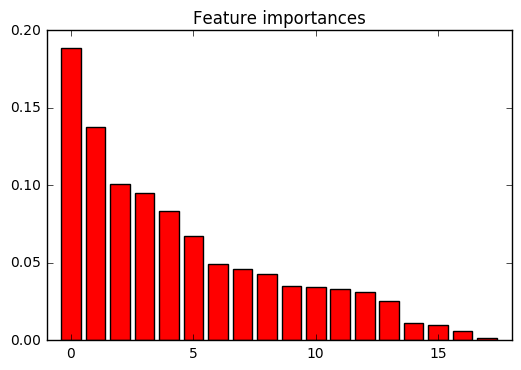

In [6]:
## Random Forest

%matplotlib inline
import matplotlib.pylab as plt

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

N_features = (columns - 1) # Se resta ID y Label, PAGA o NO PAGA
X = data_matrix[:,1:N_features]
Y = data_matrix[:,columns - 1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5, random_state = True)


clf = RandomForestClassifier(n_estimators=650, max_depth=None, bootstrap = True, n_jobs = -1)
clf.fit(X_train, Y_train)
Y_pred = clf.predict_proba(X_test)


importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print str(f+1)+". "+ features_names[indices[f]] + ": "+str(importances[indices[f]])
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices],
       color="r", align="center")
#plt.xticks(range(X_test.shape[1]), indices)
plt.xlim([-1, X_test.shape[1]])
plt.show()


In [7]:
from time import time
from sklearn import metrics
t0 = time()
pred = clf.predict(X_test)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

score = metrics.accuracy_score(Y_test, pred)
print score

test time:  0.836s
0.935483870968


[22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 46.0, 48.0, 50.0, 52.0, 54.0, 56.0, 58.0]


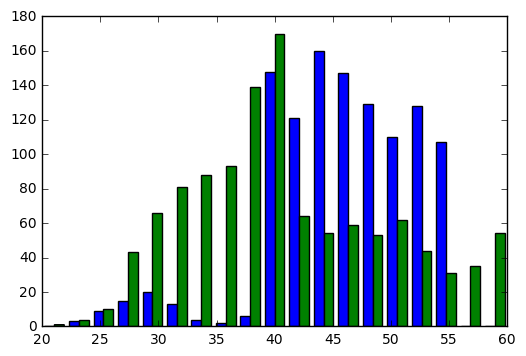

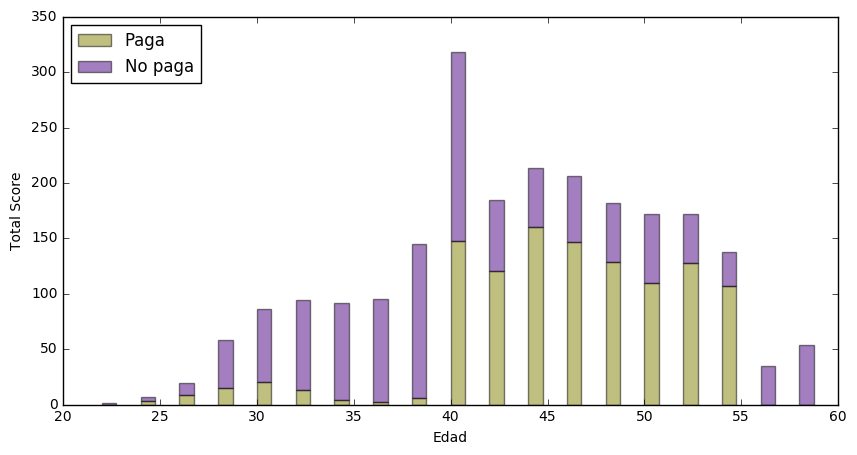

In [116]:
#Graficos en base a las caracteristicas más importantes según Random Forest

class Histogram:
    
    def __init__(self, data_matrix, feature_index, name):
        self.name = name
        self.index = feature_index
        self.data = np.zeros(shape=(rows, 2))
        
        _columns = len(data_matrix[0,:])
        self.data[:,0] = data_matrix[:, self.index]
        self.data[:,1] = data_matrix[:, _columns - 1]
        
        _N_datos = len(self.data[:,0])
        self.convert_data = np.zeros( shape = (_N_datos, 2))
    
        _Paga = 1;
        _NoPaga = 0;

        self.paga_hist = []
        self.no_paga_hist = []

        for i in range(_N_datos):
            if self.data[i,1] == _Paga:
                self.paga_hist.append( self.data[i,0])
            else:
                self.no_paga_hist.append( self.data[i,0])

    def set_bins(self, init_range, final_range, nbins):
        self.bins = plt.linspace(init_range, final_range, nbins)
        self.nbins = nbins
    
    
    def hist(self):
        _paid = self.paga_hist
        _no_paid = self.no_paga_hist
            
        x = [_paid, _no_paid]
        self.histo = plt.hist(x, self.bins)
        
        _to_bar_1 = self.histo[0][0]
        _to_bar_2 = self.histo[0][1]

        # Create the general blog and the "subplots" i.e. the bars
        f, ax1 = plt.subplots(1, figsize=(10,5))

        # Set the bar width
        bar_width = 0.75

        # positions of the left bar-boundaries
        #bar_l = [(i+1)*2.5 for i in range(len(_to_bar_1))] #+ self.bins[0]
        bar_l = [self.bins[0] + (i+1)*(self.bins[self.nbins-1] - self.bins[0])/(self.nbins) for i in range(len(_to_bar_1))]
        print [self.bins[0] + (i+1)*(self.bins[self.nbins-1] - self.bins[0])/(self.nbins) for i in range(len(_to_bar_1))] 
        
        # positions of the x-axis ticks (center of the bars as bar labels)
        tick_pos = [i+(bar_width/2) for i in bar_l] #+ self.bins[0] 

        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                # using the pre_score data
                _to_bar_1,
                # set the width
                width=bar_width,
                # with the label pre score
                label='Paga',
                # with alpha 0.5
                alpha=0.5,
                # with color
                color='#808000')

        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                # using the mid_score data
                _to_bar_2,
                # set the width
                width=bar_width,
                # with pre_score on the bottom
                bottom=_to_bar_1,
                # with the label mid score
                label='No paga',
                # with alpha 0.5
                alpha=0.5,
                # with color
                color='#4b0082')
        
        # Set the label and legends
        ax1.set_ylabel("Total Score")
        ax1.set_xlabel(self.name)
        plt.legend(loc='upper left')

        # Set a buffer around the edge
        #plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
        

## EDAD ##
a = Histogram(data_matrix, 3, "Edad")
a.set_bins(20,60, 20) ## DE 20 a 60 años, 20 intervalos
a.hist()

